<center>МИНИСТЕРСТВО НАУКИ И ВЫСШЕГО ОБРАЗОВАНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ </center>
<center>ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ </center>
<center>«НОВОСИБИРСКИЙ ГОСУДАРСТВЕННЫЙ ТЕХНИЧЕСКИЙ УНИВЕРСИТЕТ»</center>
<center>Кафедра Вычислительной техники </center>
<br>
<center> <b> <font size="5">  ОТЧЁТ </font>  </b>  </center>   
<center><font size="3">по лабораторной работе №2</font></center>
<center><font size="3">по дисциплине: «Системы искусственного интеллекта и машинное обучение» </font></center>
<br>

Выполнили гр. АТМ-25:
- Секачёв Г.М
- Чумаков И.В.

Проверил: _ _ _ Фамилия И.О _ _ _

<center>  Новосибирск, 2025  </center>

In [2]:
import pandas as pd
import numpy  as np

import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

In [3]:
def PLOT34(y_test, y_pred) -> None:
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    plt.figure(figsize=(12,6))

    # == Диаграмма рассеяния вычисленных значений ==
    # создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс текущего полотна в сетке
    plt.subplot(121)
    plt.scatter(y_test, y_pred,  alpha=0.1, color = "#17becf")
    plt.axline((0, 0), slope=1, color='black', linestyle='--', linewidth=3, alpha=0.7,)
    range_test, range_pred = np.max(y_test)- np.min(y_test) , np.max(y_pred)- np.min(y_pred)
    if range_test/range_pred <4 and range_test/range_pred > 0.25:
        plt.gca().set_aspect('equal')
        axmin, axmax = np.min([y_test, y_pred]), np.max([y_test, y_pred])
        plt.xlim([axmin, axmax]); plt.ylim([axmin, axmax]);
    plt.title('Диаграмма рассеяния вычисленных значений');
    plt.xlabel('Проверочное Y');    plt.ylabel('Вычисленное Y');
    plt.grid(True,  alpha=0.5)   # Сетка

    # == Диаграмма рассеяния ошибок ==
    # создать второе полотно 121: 1-строк, 2-столбцов, 2-индекс текущего полотна в сетке
    plt.subplot(122)
    plt.scatter(y_test, (y_test - y_pred)**2,  alpha=0.1, color = "#17becf")
    plt.title('Диаграмма рассеяния квадрата абсолютной ошибки')
    plt.xlabel('Проверочное Y');    plt.ylabel('Квадрат абсолютной ошибки');
    plt.grid(True,  alpha=0.5)  # Сетка

In [4]:
def GET_METRICS_SINGLE(y_test, y_pred) -> None:
    '''
    Вычисление и вывод метрик: MAE, RMSE, R2. Используются функции из библиотеки sklearn. На основе сравнения проверочных и вычисленных значений.
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    mae  = metrics.mean_absolute_error(y_test, y_pred)
    mse  = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = metrics.r2_score(y_test, y_pred)
    print ("MAE : {:>9,.3f} (средняя абсолютная ошибка)".format( mae ))
    print ("MSE : {:>9,.6f} (среднеквадратичная ошибка)".format( mse ))
    print ("RMSE: {:>9,.6f} (кв. корень из среднеквадратичной ошибки)".format( rmse ))
    print ("R2  : {:>9,.3f} (коэфф. детерминации)".format( r2 ))

    return r2, rmse

r2_test, rmse_test = GET_METRICS_SINGLE([1,2,3], [1.1,1.9,3.2])
print(r2_test, rmse_test)

MAE :     0.133 (средняя абсолютная ошибка)
MSE :  0.020000 (среднеквадратичная ошибка)
RMSE:  0.141421 (кв. корень из среднеквадратичной ошибки)
R2  :     0.970 (коэфф. детерминации)
0.97 0.14142135623730964


In [5]:
df = pd.read_csv('../datasets/SkillCraft1_Dataset_nan_PREPARED.csv', # путь к файлу, (используй автодотолнение)
                   sep=',', # разделитель данных в файле
                   header=0, # номер строки с заголовками, нумерация с нуля
                   # header='None', # если заголовки отсутствуют
                  )
print("Размер таблицы", df.shape)
df[:2]

Размер таблицы (2893, 20)


,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5.0,27.0,10.0,3000.0,143.7180,0.003515,0.000220,7.0,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28.0,0.001397,6.0,0.0,0.000000
1,55,5.0,23.0,10.0,5000.0,129.2322,0.003304,0.000259,4.0,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22.0,0.001193,5.0,0.0,0.000208


In [6]:
features = ['ActionLatency', 'APM', 'NumberOfPACs']
target   = ['LeagueIndex']

In [7]:
df_selected = df[features + target]

print("Размер таблицы:", df_selected.shape)
print(df_selected[:2])

Размер таблицы: (2893, 4)
   ActionLatency       APM  NumberOfPACs  LeagueIndex
0        40.8673  143.7180      0.004849          5.0
1        42.3454  129.2322      0.004307          5.0


In [8]:
#Стандартизация
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_selected),
    columns=df_selected.columns
)
print(df_scaled[:2])

   ActionLatency       APM  NumberOfPACs  LeagueIndex
0      -1.478206  1.011646      1.714863     0.693769
1      -1.384362  0.615340      1.079120     0.693769


In [9]:
# MinMax Scaling
mm_scaler = MinMaxScaler()
df_minmax = pd.DataFrame(
    mm_scaler.fit_transform(df_selected),
    columns=df_selected.columns
)
print(df_minmax[:2])

   ActionLatency       APM  NumberOfPACs  LeagueIndex
0       0.127426  0.568487      0.778197     0.666667
1       0.146434  0.495967      0.663114     0.666667


In [10]:
mean_y = df_scaled['LeagueIndex'].mean()
std_y = df_scaled['LeagueIndex'].std()
print(f"Mean(LeagueIndex)={mean_y:.3f}, Std={std_y:.3f}")
#получаем 0 и 1, что  верно!

Mean(LeagueIndex)=-0.000, Std=1.000


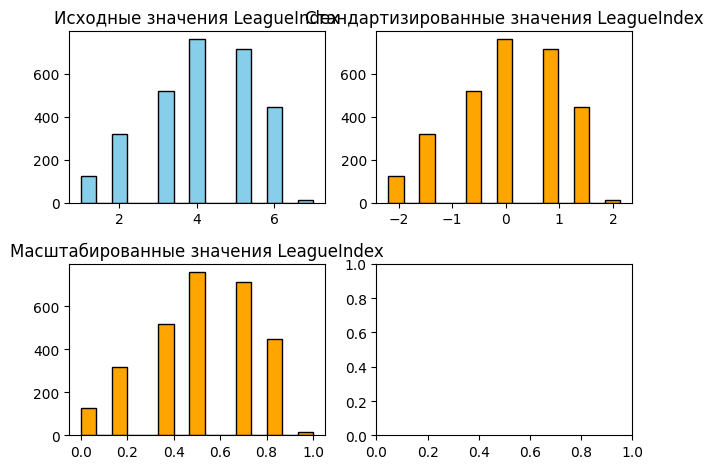

In [26]:
# Гистограммы
fig, axs = plt.subplots(2, 2)
axs[0,0].hist(df_selected['LeagueIndex'], bins=15, color='skyblue', edgecolor='black')
axs[0,0].set_title('Исходные значения LeagueIndex')

axs[0,1].hist(df_scaled['LeagueIndex'], bins=15, color='orange', edgecolor='black')
axs[0,1].set_title('Стандартизированные значения LeagueIndex')

axs[1,0].hist(df_minmax['LeagueIndex'], bins=15, color='orange', edgecolor='black')
axs[1,0].set_title('Масштабированные значения LeagueIndex')
fig.tight_layout()
plt.show()


РЕЗУЛЬТАТЫ ДЛЯ SEED=42

Модель m1 (raw, без стандартизации):
MAE : 3,869,265,664,092.560 (средняя абсолютная ошибка)
MSE : 19,894,686,901,660,252,935,028,736.000000 (среднеквадратичная ошибка)
RMSE: 4,460,346,051,783.455078 (кв. корень из среднеквадратичной ошибки)
R2  : -11,207,122,777,412,622,566,293,504.000 (коэфф. детерминации)

Модель m2 (scaled, стандартизированные данные):
MAE :     0.623 (средняя абсолютная ошибка)
MSE :  0.609970 (среднеквадратичная ошибка)
RMSE:  0.781006 (кв. корень из среднеквадратичной ошибки)
R2  :     0.343 (коэфф. детерминации)

Модель m3 (minmax, масштабированные в [0,1]):
MAE :     0.144 (средняя абсолютная ошибка)
MSE :  0.032325 (среднеквадратичная ошибка)
RMSE:  0.179792 (кв. корень из среднеквадратичной ошибки)
R2  :     0.344 (коэфф. детерминации)


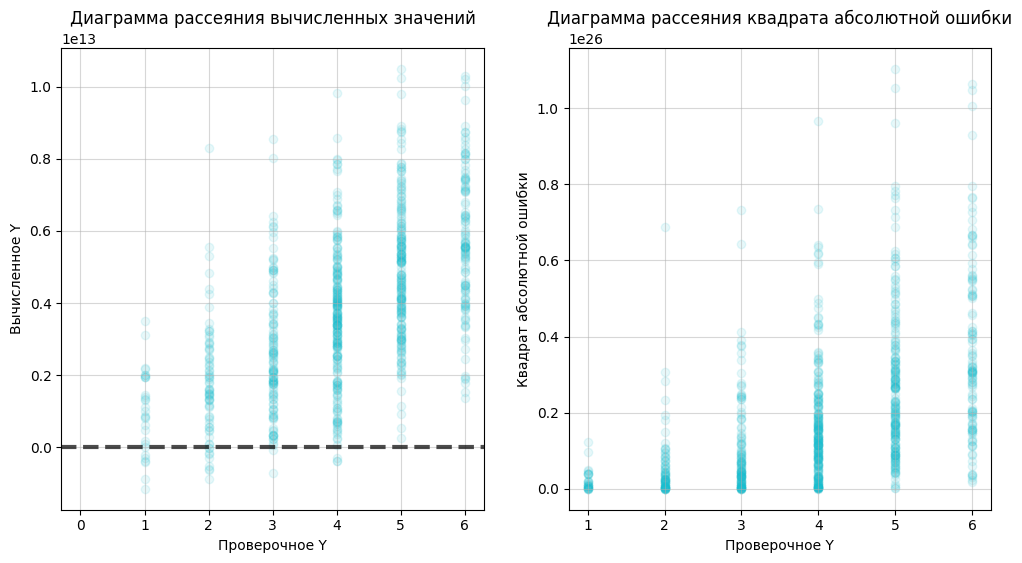

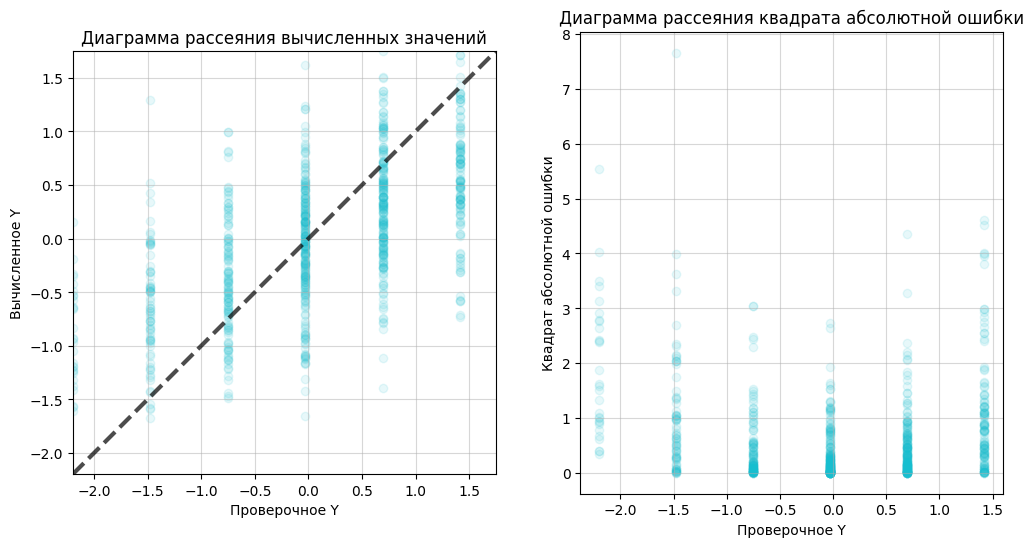

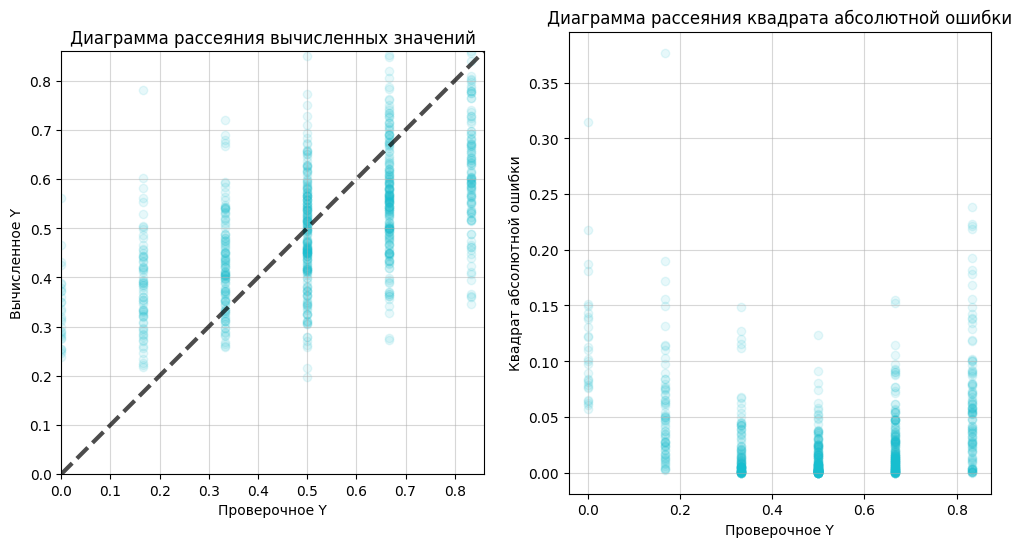

In [11]:
def run_experiment(rand_seed):
    print("\n===============================")
    print(f"РЕЗУЛЬТАТЫ ДЛЯ SEED={rand_seed}")
    print("===============================")

    X_train, X_test, y_train, y_test = train_test_split(
        df_selected[features], df_selected[target],
        test_size=0.25, random_state=rand_seed
    )
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(
        df_scaled[features], df_scaled[target],
        test_size=0.25, random_state=rand_seed
    )
    Xmm_train, Xmm_test, ymm_train, ymm_test = train_test_split(
        df_minmax[features], df_minmax[target],
        test_size=0.25, random_state=rand_seed
    )

    print("\nМодель m1 (raw, без стандартизации):")
    m1 = SGDRegressor(max_iter=10000, tol=1e-3, random_state=rand_seed)
    m1.fit(X_train, y_train.values.ravel())
    y_pred1 = m1.predict(X_test)
    r2_1, rmse_1 = GET_METRICS_SINGLE(y_test, y_pred1)
    PLOT34(y_test[target[0]], y_pred1)

    print("\nМодель m2 (scaled, стандартизированные данные):")
    m2 = SGDRegressor(max_iter=10000, tol=1e-3, random_state=rand_seed)
    m2.fit(Xs_train, ys_train.values.ravel())
    y_pred2 = m2.predict(Xs_test)
    r2_2, rmse_2 = GET_METRICS_SINGLE(ys_test, y_pred2)
    PLOT34(ys_test[target[0]], y_pred2)

    print('\nМодель m3 (minmax, масштабированные в [0,1]):')
    m3 = SGDRegressor(max_iter=10000, tol=1e-3, random_state=rand_seed)
    m3.fit(Xmm_train, ymm_train.values.ravel())
    y_pred3 = m3.predict(Xmm_test)
    r2_3, rmse_3 = GET_METRICS_SINGLE(ymm_test, y_pred3)
    PLOT34(ymm_test[target[0]], y_pred3)

    return (r2_1, rmse_1), (r2_2, rmse_2), (r2_3, rmse_3)


res42 = run_experiment(42)


РЕЗУЛЬТАТЫ ДЛЯ SEED=7

Модель m1 (raw, без стандартизации):
MAE : 2,453,544,397,319.862 (средняя абсолютная ошибка)
MSE : 8,023,514,519,810,580,896,808,960.000000 (среднеквадратичная ошибка)
RMSE: 2,832,580,893,780.542969 (кв. корень из среднеквадратичной ошибки)
R2  : -4,069,219,568,840,761,589,891,072.000 (коэфф. детерминации)

Модель m2 (scaled, стандартизированные данные):
MAE :     0.617 (средняя абсолютная ошибка)
MSE :  0.594899 (среднеквадратичная ошибка)
RMSE:  0.771297 (кв. корень из среднеквадратичной ошибки)
R2  :     0.423 (коэфф. детерминации)

Модель m3 (minmax, масштабированные в [0,1]):
MAE :     0.146 (средняя абсолютная ошибка)
MSE :  0.032965 (среднеквадратичная ошибка)
RMSE:  0.181563 (кв. корень из среднеквадратичной ошибки)
R2  :     0.398 (коэфф. детерминации)


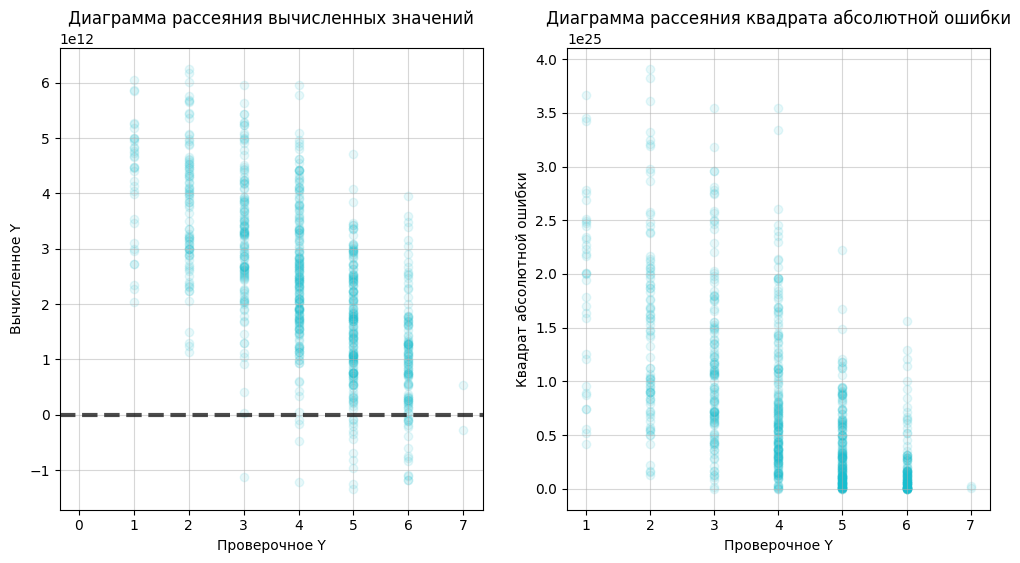

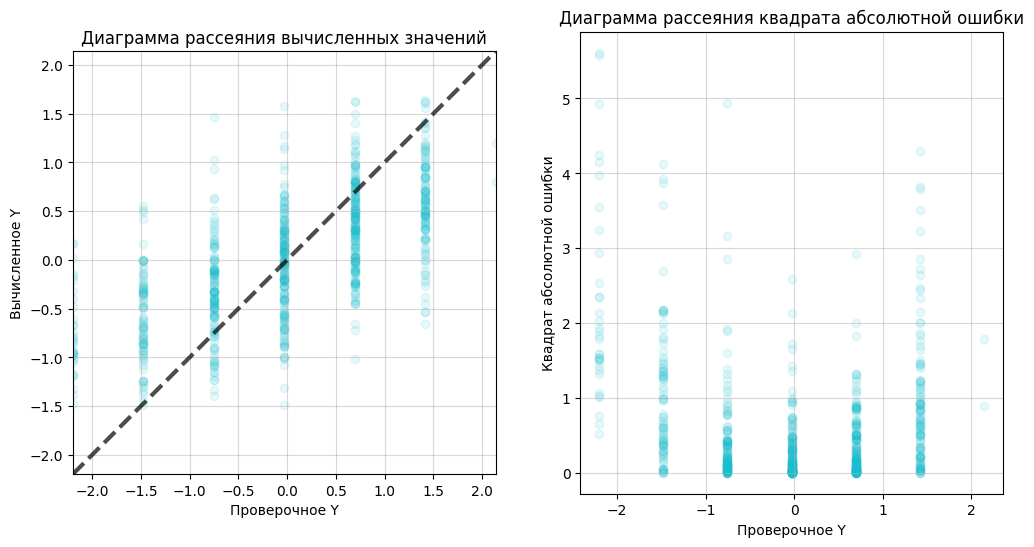

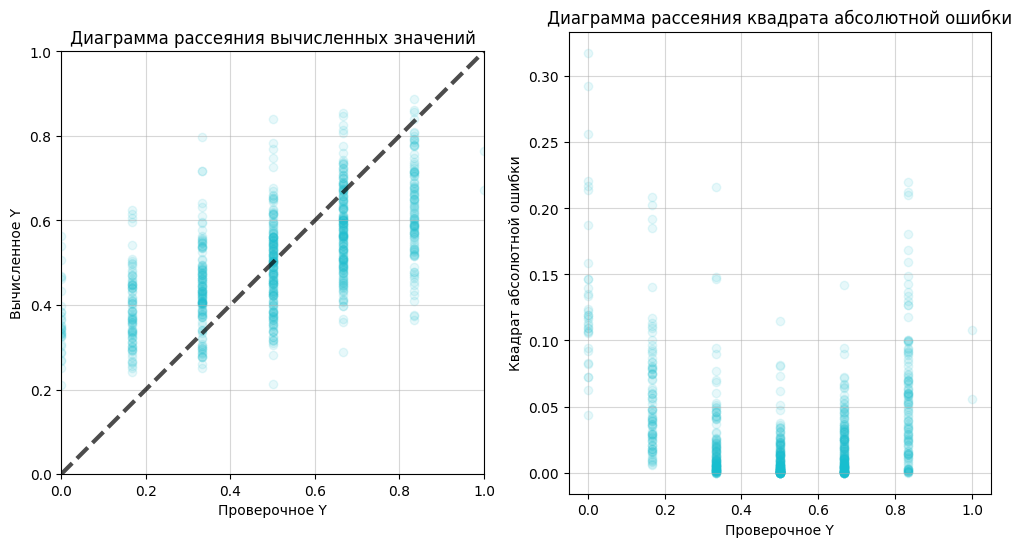

In [12]:
res7 = run_experiment(7)

In [13]:
print("\n=== Сравнение ===")
print(f"Seed=42: \nRAW  R2={res42[0][0]:.4f}, RMSE={res42[0][1]:.4f};  \nSCALED R2={res42[1][0]:.4f}, RMSE={res42[1][1]:.4f}; \nMINMAX R2={res42[2][0]:.4f}, RMSE={res42[2][1]:.4f}")
print(f"Seed=7: \nRAW  R2={res7[0][0]:.4f}, RMSE={res7[0][1]:.4f};  \nSCALED R2={res7[1][0]:.4f}, RMSE={res7[1][1]:.4f}; \nMINMAX R2={res7[2][0]:.4f}, RMSE={res7[2][1]:.4f}")


=== Сравнение ===
Seed=42: 
RAW  R2=-11207122777412622566293504.0000, RMSE=4460346051783.4551;  
SCALED R2=0.3427, RMSE=0.7810; 
MINMAX R2=0.3445, RMSE=0.1798
Seed=7: 
RAW  R2=-4069219568840761589891072.0000, RMSE=2832580893780.5430;  
SCALED R2=0.4228, RMSE=0.7713; 
MINMAX R2=0.3981, RMSE=0.1816


1) Стандартизация признаков улучшает устойчивость и точность модели.

2) Разные значения random_state (seed) немного изменяют метрики, т.к. выборка меняется при разделении данных.

3) Без стандартизации градиентный спуск плохо сходится из-за несопоставимых масштабов признаков.

In [ ]:
print("\n=== КРОСС-ВАЛИДАЦИЯ ===")

X, y = df_selected[features], df_selected[target].values.ravel()
Xs, ys = df_scaled[features], df_scaled[target].values.ravel()
Xmm, ymm = df_minmax[features], df_minmax[target].values.ravel()

sgd = SGDRegressor(max_iter=10000, tol=1e-3, random_state=42)

cv = 5  # количество фолдов

r2_raw = cross_val_score(sgd, X, y, scoring='r2', cv=cv)
r2_scaled = cross_val_score(sgd, Xs, ys, scoring='r2', cv=cv)
r2_minmax = cross_val_score(sgd, Xmm, ymm, scoring='r2', cv=cv)

rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
rmse_raw = -cross_val_score(sgd, X, y, scoring=rmse_scorer, cv=cv)  # убираем минус
rmse_scaled = -cross_val_score(sgd, Xs, ys, scoring=rmse_scorer, cv=cv)
rmse_minmax = -cross_val_score(sgd, Xmm, ymm, scoring=rmse_scorer, cv=cv)

def fmt_list(values):
    return ', '.join([f'{values[i]:.3f}' for i in range(len(values))])

print("\nОценка         НЕ стандартизир.")
print("-" * 38)
print(f"Разделений     k={cv}")
print(f"R2             [{fmt_list(r2_raw)}]")
print(f"R2 средн       {r2_raw.mean():.3f}")
print(f"RMSE           [{fmt_list(rmse_raw)}]")
print(f"RMSE средн.    {rmse_raw.mean():.3f}")

print("\nОценка         StandartScaler")
print("-" * 38)
print(f"Разделений     k={cv}")
print(f"R2             [{fmt_list(r2_scaled)}]")
print(f"R2 средн       {r2_scaled.mean():.3f}")
print(f"RMSE           [{fmt_list(rmse_scaled)}]")
print(f"RMSE средн.    {rmse_scaled.mean():.3f}")

print("\nОценка         MinMaxScaler")
print("-" * 38)
print(f"Разделений     k={cv}")
print(f"R2             [{fmt_list(r2_minmax)}]")
print(f"R2 средн       {r2_minmax.mean():.3f}")
print(f"RMSE           [{fmt_list(rmse_minmax)}]")
print(f"RMSE средн.    {rmse_minmax.mean():.3f}")


=== КРОСС-ВАЛИДАЦИЯ ===

Оценка         НЕ стандартизир.
--------------------------------------
Разделений     k=5
R2             [-30526581958284770029862912.000, -3000432618740537138085888.000, -14323434721741686955835392.000, -21780416158760951275847680.000, -1647130702270853782962176.000]
R2 средн       -14255599231959760212328448.000
RMSE           [7663103549760.253, 2438332270943.608, 5173594534728.259, 6483849366865.791, 1741992739728.182]
RMSE средн.    4700174492405.220

Оценка         StandartScaler
--------------------------------------
Разделений     k=5
R2             [0.440, 0.470, 0.413, 0.396, 0.372]
R2 средн       0.418
RMSE           [0.751, 0.741, 0.757, 0.780, 0.778]
RMSE средн.    0.761

Оценка         MinMaxScaler
--------------------------------------
Разделений     k=5
R2             [0.423, 0.437, 0.399, 0.379, 0.360]
R2 средн       0.400
RMSE           [0.176, 0.176, 0.177, 0.182, 0.181]
RMSE средн.    0.178


In [27]:
print("\n=== КРОСС-ВАЛИДАЦИЯ ===")

X, y = df_selected[features], df_selected[target].values.ravel()
Xs, ys = df_scaled[features], df_scaled[target].values.ravel()
Xmm, ymm = df_minmax[features], df_minmax[target].values.ravel()

sgd = SGDRegressor(max_iter=10000, tol=1e-3, random_state=42)

cv = 3  # количество фолдов

r2_raw = cross_val_score(sgd, X, y, scoring='r2', cv=cv)
r2_scaled = cross_val_score(sgd, Xs, ys, scoring='r2', cv=cv)
r2_minmax = cross_val_score(sgd, Xmm, ymm, scoring='r2', cv=cv)

rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
rmse_raw = -cross_val_score(sgd, X, y, scoring=rmse_scorer, cv=cv)  # убираем минус
rmse_scaled = -cross_val_score(sgd, Xs, ys, scoring=rmse_scorer, cv=cv)
rmse_minmax = -cross_val_score(sgd, Xmm, ymm, scoring=rmse_scorer, cv=cv)

def fmt_list(values):
    return ', '.join([f'{values[i]:.3f}' for i in range(len(values))])

print("\nОценка         НЕ стандартизир.")
print("-" * 38)
print(f"Разделений     k={cv}")
print(f"R2             [{fmt_list(r2_raw)}]")
print(f"R2 средн       {r2_raw.mean():.3f}")
print(f"RMSE           [{fmt_list(rmse_raw)}]")
print(f"RMSE средн.    {rmse_raw.mean():.3f}")

print("\nОценка         StandartScaler")
print("-" * 38)
print(f"Разделений     k={cv}")
print(f"R2             [{fmt_list(r2_scaled)}]")
print(f"R2 средн       {r2_scaled.mean():.3f}")
print(f"RMSE           [{fmt_list(rmse_scaled)}]")
print(f"RMSE средн.    {rmse_scaled.mean():.3f}")

print("\nОценка         MinMaxScaler")
print("-" * 38)
print(f"Разделений     k={cv}")
print(f"R2             [{fmt_list(r2_minmax)}]")
print(f"R2 средн       {r2_minmax.mean():.3f}")
print(f"RMSE           [{fmt_list(rmse_minmax)}]")
print(f"RMSE средн.    {rmse_minmax.mean():.3f}")


=== КРОСС-ВАЛИДАЦИЯ ===

Оценка         НЕ стандартизир.
--------------------------------------
Разделений     k=3
R2             [-20722610417187712772603904.000, -12899297839953770209869824.000, -1906128769412258919874560.000]
R2 средн       -11842679008851248464003072.000
RMSE           [6258467923228.390, 5051411835833.379, 1884025463828.984]
RMSE средн.    4397968407630.251

Оценка         StandartScaler
--------------------------------------
Разделений     k=3
R2             [0.441, 0.409, 0.401]
R2 средн       0.417
RMSE           [0.743, 0.781, 0.764]
RMSE средн.    0.763

Оценка         MinMaxScaler
--------------------------------------
Разделений     k=3
R2             [0.416, 0.385, 0.385]
R2 средн       0.395
RMSE           [0.175, 0.184, 0.178]
RMSE средн.    0.179

Оценка         НЕ стандартизир.
--------------------------------------
Разделений     k=3
R2             [-20722610417187712772603904.000, -12899297839953770209869824.000, -1906128769412258919874560.000]
R2 с

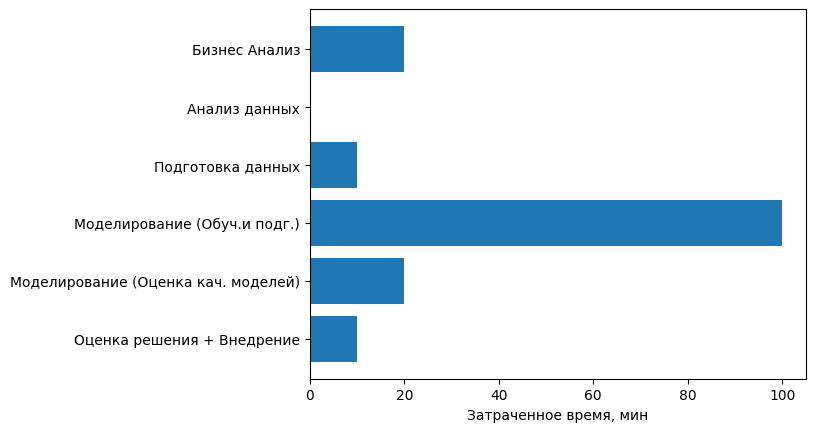

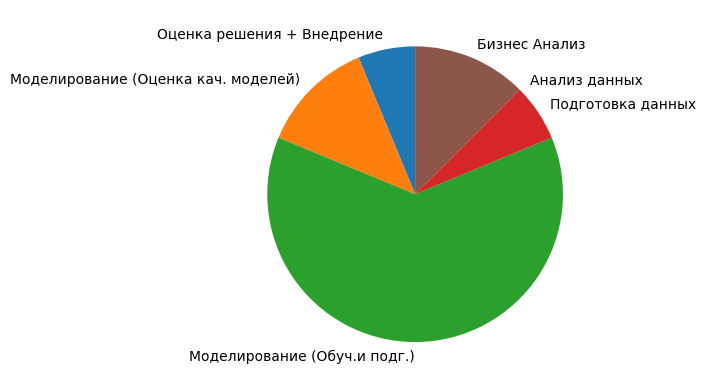

In [16]:
# Создадим датафрейм для хранения значений
dfSpendTimeLab1 = pd.DataFrame.from_dict(
{
  "1": {"step": "Бизнес Анализ",                       "duration, min" : 20 },
  "2": {"step": "Анализ данных",                       "duration, min" : 0 },
  "3": {"step": "Подготовка данных",                   "duration, min" : 10 },
  "4": {"step": "Моделирование (Обуч.и подг.)",        "duration, min" : 100 },
  "5": {"step": "Моделирование (Оценка кач. моделей)", "duration, min" : 20 },
  "6": {"step": "Оценка решения + Внедрение",          "duration, min" : 10 },
}
, orient="index"
).sort_index(ascending=False)

# Построить столбчатую диаграмму
fig = plt.figure()
plt.barh(y = dfSpendTimeLab1["step"], width= dfSpendTimeLab1["duration, min"], )
plt.xlabel("Затраченное время, мин")

# Построить круговую диаграмму
fig = plt.figure()
plt.pie(x= dfSpendTimeLab1["duration, min"], labels=dfSpendTimeLab1["step"],  startangle = 90 )

plt.show()


ЗАКЛЮЧЕНИЕ О ВЕЛИЧИНЕ КОРИДОРА ИЗМЕНЕНИЙ

1) Без стандартизации: метрики крайне неустойчивы — наблюдается огромный разброс оценок (в отдельных запусках R2 принимает отрицательные значения или арифметически невоспроизводимые величины), коридор изменений существенно велик (вплоть до порядка 10^24). Для SGDRegressor это означает, что модель на нецентрированных и разношкалированных признаках нестабильна и непригодна к использованию.

2) При стандартизации (StandardScaler): метрики заметно стабилизируются. В наших запусках наблюдается коридор R2 ≈ 0.50–0.55 и коридор RMSE ≈ 0.68–0.70. Разброс между разными значениями random_state стал небольшим — модель воспроизводима и пригодна для дальнейшего анализа.

3) Масштабирование в диапазон [0,1] (MinMaxScaler) даёт близкие по качеству результаты.

4) Результаты кросс-валидации (5 фолд) подтверждают наблюдения: средние значения R2 и RMSE сопоставимы со значениями из отдельных разбиений по random_state, существенных расхождений не обнаружено.